## From Graphs to Glam: A Fashion Recommendation Agent with LangChain and Neo4j based on Knowledge Graph RAG LLMs


Graph-based recommendation systems are powerful tools for building personalized experiences. By leveraging the Neo4j graph database and LangChain's capabilities, we can model interconnected entities and relationships to create an intelligent recommendation engine.

In this tutorial, we will use Neo4j for data storage and retrieval and LangChain to process natural language inputs in tabular (CSV) format. The goal is to create a fashion assistant that recommends outfits from the item catalog based on gender and event type (other attributes can be easily added). The recommender agent will use LLMs to query a knowledge graph as a Graph RAG.

The main components of this project are as follows:



1.   Build a knowledge graph from a CSV fashion dataset, perform entity extraction, and query it via LLMs.

2.   Build a Graph RAG to retrieve outfits based on the gender and event type of the person attending.

3.   Create another knowledge graph using structured input/output data and link it to the existing knowledge graph.

4.   LDevelop an enhanced Graph RAG that leverages the final knowledge graph to recommend outfits based on gender and event type.

5.   Design the final recommender agent that queries the knowledge graph and uses the LLM-based recommendation system to find matched outfits available in the product catalog. Finally, display images and details of the recommended products.

**Step 1: Set up the environment**

To begin, we install the required Python libraries and import dependencies.

```
# This is formatted as code
```



In [1]:
%pip install --upgrade --quiet  langchain langchain-community neo4j langchain_experimental langchain_groq yfiles_jupyter_graphs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00


In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain.chains import GraphCypherQAChain
from typing import List
from langchain_community.graphs import Neo4jGraph
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
import os
import pandas as pd
import json
import re
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


**Step 2: Connect to a Neo4j instance**

We need to create a free Neo4j (Aura) instance and connect to a it. See [here](https://console.neo4j.io/).

We then configure the Neo4j connection:

In [3]:
# Use the credentials from your instance
NEO4J_URI = "neo4j+s"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "pass"

In [4]:
# connect to the Neo4j instance
os.environ["NEO4J_URI"] = NEO4J_URI
os.environ["NEO4J_USERNAME"] = NEO4J_USERNAME
os.environ["NEO4J_PASSWORD"] = NEO4J_PASSWORD

graph = Neo4jGraph()

**Step 3: Load the Dataset**

We'll use a dataset containing fashion products as follows.

In [5]:
url = "https://raw.githubusercontent.com/MPAghababa/llms/main/graph_rag/myntra_products_catalog_clean1.csv"
products_df = pd.read_csv(url)
products_df.head(3)

,ProductID,ProductName,ProductBrand,Gender,Price,Description,PrimaryColor
0,10017413,DKNY Unisex Black Grey Printed Medium Trolley...,DKNY,Unisex,11745,"Black and grey printed medium trolley bag, sec...",Black
1,10016283,EthnoVogue Women Beige Grey Made to Measure C...,EthnoVogue,Women,5810,Beige Grey made to measure kurta with churida...,Beige
2,10009781,SPYKAR Women Pink Alexa Super Skinny Fit HighR...,SPYKAR,Women,899,Pink coloured wash 5pocket highrise cropped je...,Pink


**Step 4: Construct the knowledge graph**

Next, we populate the Neo4j graph with nodes for products, brands, colors, and other attributes using the following cypher query (first we remove available info from the graph, if any).

In [6]:
# Delete available info from the graph

query = """ MATCH (n)
DETACH DELETE n"""

graph.query(query)

[]

In [7]:
### Load the dataset of products

product_query="""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MPAghababa/llms/main/graph_rag/myntra_products_catalog_clean_images.csv" AS row
WITH row
WHERE row.ProductID IS NOT NULL AND trim(row.ProductID) <> ''
// Creating Product Nodes
MERGE (p:Product {id: row.ProductID})
SET p.name = row.ProductName,
    p.price = toFloat(row.`Price`),
    p.description = row.Description,
    p.images = row.images

// Create Brand Node and Relationship
MERGE (b:Brand {name: trim(row.ProductBrand)})
MERGE (p)-[:BRANDS]->(b)  // Relationship between Product and Brand

// Create Gender Node and Relationship
MERGE (g:Gender {type: trim(row.Gender)})
MERGE (p)-[:HAS_GENDER]->(g)   // Relationship between Product and Gender

// Color Node and Relationship (Only if PrimaryColor is available)
WITH row, p
WHERE row.PrimaryColor IS NOT NULL AND trim(row.PrimaryColor) <> ''
MERGE (co:Color {name: trim(row.PrimaryColor)})
MERGE (p)-[:HAS_COLOR]->(co)    // Relationship between Product and Color
"""

In [8]:
# Apply the cypher query to the graph
graph.query(product_query)

[]

In [9]:
# Display the schema of the graph
graph.refresh_schema()
print(graph.schema)

Node properties:
Product {id: STRING, name: STRING, price: FLOAT, description: STRING, images: STRING}
Brand {name: STRING}
Gender {type: STRING}
Color {name: STRING}
Relationship properties:

The relationships:
(:Product)-[:BRANDS]->(:Brand)
(:Product)-[:HAS_GENDER]->(:Gender)
(:Product)-[:HAS_COLOR]->(:Color)


**Step 5: Visualizing the Graph**

To validate the graph structure, we use the yfiles_jupyter_graphs library to visualize the nodes and relationships.

In [10]:
default_cypher = "MATCH (sub)-[rel:!MENTIONS]->(tar) RETURN sub,rel,tar LIMIT 300"

def showGraph(cypher: str = default_cypher):

    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

**Step 6: Retrieve Entities from user inputs**

To retrieve structured information, we use LangChain with Groq's LLM (see [here](https://console.groq.com/)). For simplicity, we guide the LLM to detect brand, color, and gender.

You can specify the type of LLM to be used for the knowledge graph generation chain. Keep in mind that the quality of the generated graph heavily relies on the chosen model, so it is best to use the most advanced one available cosidering the resources and other constraints.

In [11]:
# Use your groq credentials (api key)
groq_api_key = "key"

In [12]:
# Choose the model type and create the LLM
llm = ChatGroq(groq_api_key=groq_api_key,model_name="llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7db2cdee6ad0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7db2cdefe8c0>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

Now, we can define the retriever. First, we define the entity extraction class for brands, colors, and genders. Then, we define the entity extraction prompt
and pass the structured output model to the LLM using chain tool of LangChain.

In [13]:
class ProductEntities(BaseModel):
    """Extracted information about product entities."""
    brands: List[str] = Field(..., description="All brands mentioned in the text")
    colors: List[str] = Field(..., description="All colors mentioned in the text")
    genders: List[str] = Field(..., description="All gender categories mentioned in the text")

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "We are extracting product brands, colors, and gender categories from the input text.",
        ),
        (
            "user",
            "Use the given format to extract entities from the following: input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(ProductEntities)

Below is an example of entity extraction.

In [14]:
input_text = "Nike has men's red sneakers and women's blue jackets."

response = entity_chain.invoke({"question": input_text})

print("Extracted Brands:", response.brands)
print("Extracted Colors:", response.colors)
print("Extracted Genders:", response.genders)

print(response)


Extracted Brands: ['Nike']
Extracted Colors: ['red', 'blue']
Extracted Genders: ["men's", "women's"]
brands=['Nike'] colors=['red', 'blue'] genders=["men's", "women's"]


**Step 7: Query the graph**

We can use LangChain to query the graph to realize question-answering against a graph (by generating cypher statements). Note that we could use separate LLMs for cypher query and answer generation.

In [15]:
chain = GraphCypherQAChain.from_llm(llm=llm,graph=graph,verbose=True, allow_dangerous_requests='True', top_k=2,)
chain

# If you want to use separate LLMs for cypher query and answer generation, uncomment the followings.

# llm_qa=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
# chain=GraphCypherQAChain.from_llm(llm=llm,qa_llm=llm_qa,graph=graph,verbose=True, allow_dangerous_requests='True', top_k=2)
# chain

GraphCypherQAChain(verbose=True, graph=<langchain_community.graphs.neo4j_graph.Neo4jGraph object at 0x7db30147a920>, cypher_generation_chain=LLMChain(verbose=False, prompt=PromptTemplate(input_variables=['question', 'schema'], input_types={}, partial_variables={}, template='Task:Generate Cypher statement to query a graph database.\nInstructions:\nUse only the provided relationship types and properties in the schema.\nDo not use any other relationship types or properties that are not provided.\nSchema:\n{schema}\nNote: Do not include any explanations or apologies in your responses.\nDo not respond to any questions that might ask anything else than for you to construct a Cypher statement.\nDo not include any text except the generated Cypher statement.\n\nThe question is:\n{question}'), llm=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7db2cdee6ad0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7db2cdefe8c0>, model_name='llama3-70b-

Below are several examples of quering the knowlwdge graph via LLMs. Note that you may need to execute the commands several times to get the answer.

In [41]:
response=chain.invoke({"query":"What do you know about MBE Women Orange Checked Dupatta? Do you have its price?"})

response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product {name: "MBE Women Orange Checked Dupatta"})-[:BRANDS]->(b:Brand) 
OPTIONAL MATCH (p)-[:HAS_GENDER]->(g:Gender) 
OPTIONAL MATCH (p)-[:HAS_COLOR]->(c:Color) 
RETURN p.price AS price, p.name AS name, b.name AS brand, g.type AS gender, c.name AS color;
Full Context:
[{'price': 623.0, 'name': 'MBE Women Orange Checked Dupatta', 'brand': 'MBE', 'gender': 'Women', 'color': 'Orange'}]

> Finished chain.


{'query': 'What do you know about MBE Women Orange Checked Dupatta? Do you have its price?',
 'result': 'The MBE Women Orange Checked Dupatta is a product by MBE, specifically designed for women, and it comes in an orange color. Its price is 623.0.'}

In [42]:
response=chain.invoke({"query":"what kind of items do we have there? Give me three of them"})

response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product) RETURN p.name LIMIT 3
Full Context:
[{'p.name': 'Flying Machine Men Blue Slim Tapered Michael Fit MidRise Clean Look Stretchable Jeans'}, {'p.name': 'Mast  Harbour Men Dusty Pink Washed Denim Jacket'}]

> Finished chain.


{'query': 'what kind of items do we have there? Give me three of them',
 'result': 'We have jeans and jackets. Specifically, we have Flying Machine Men Blue Slim Tapered Michael Fit MidRise Clean Look Stretchable Jeans and Mast Harbour Men Dusty Pink Washed Denim Jacket.'}

In [19]:
response=chain.invoke({"query":"find three cheapest products"})

response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product) RETURN p ORDER BY p.price LIMIT 3
Full Context:
[{'p': {'images': 'http://assets.myntassets.com/assets/images/10248145/2019/7/30/63ba85a1-5700-423d-b5df-152542eef6e51564494594042-US-Polo-Assn-Men-Innerwear-Vests-7311564494592994-1.jpg ~ http://assets.myntassets.com/assets/images/10248145/2019/7/30/a4eb10e4-7cdf-4ebd-938a-95e9155116ef1564494594027-US-Polo-Assn-Men-Innerwear-Vests-7311564494592994-2.jpg ~ http://assets.myntassets.com/assets/images/10248145/2019/7/30/d392d04d-586e-4dbc-9736-f7d367151a6c1564494594010-US-Polo-Assn-Men-Innerwear-Vests-7311564494592994-3.jpg ~ http://assets.myntassets.com/assets/images/10248145/2019/7/30/49a2ad53-7c77-4ecf-bf47-3522cd2a87881564494593996-US-Polo-Assn-Men-Innerwear-Vests-7311564494592994-4.jpg ~ http://assets.myntassets.com/assets/images/10248145/2019/7/30/b5612430-d003-4e70-bbc9-3fd2d9e1ec311564494593984-US-Polo-Assn-Men-Innerwear-Vests-7311564494592994-5.jpg', 'p

{'query': 'find three cheapest products',
 'result': 'The three cheapest products are US Polo Assn Men White Solid Innerwear Vests I661001P1 for 153.0, Clovia Women Blue Self Design Laced Low Rise Boyshorts for 199.0, and no other product is cheaper than these two.'}

In [48]:
response=chain.invoke({"query":"Give me two outfilts for women attending a party"})

response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product)-[:HAS_GENDER]->(g:Gender {type: 'Female'})-[:HAS_COLOR]->(c:Color) 
WHERE p.price < 100 AND c.name IN ['Red', 'Pink'] 
RETURN p.name, p.price, c.name ORDER BY p.price DESC LIMIT 2
Full Context:
[]

> Finished chain.


{'query': 'Give me two outfilts for women attending a party',
 'result': "I don't know the answer."}

**Step 8: Build the graph RAG recommendation system to the pipeline**

We further enrich the graph with recommendations for specific events. We use a dataset to add nodes and relationships for recommendations. We will use this knowledge grapg to accomplish Graph RAG for a fashion assistant recommender system.

The adopted dataset is a style recommendation dataset that contains input (body type and personal clothing style), context (event context) and response triplets. The responses in the dataset are GPT 3.5 generated outfit combination recommendations given the input body type and personal style prompt and the target / context event. See [here](https://huggingface.co/datasets/neuralwork/fashion-style-instruct).

In [21]:
# Load the fashion dataset
file_path = "https://raw.githubusercontent.com/MPAghababa/llms/main/graph_rag/fashion_style_instruct_train.csv"

fashion_data = pd.read_csv(file_path)

fashion_data.head(3)

,input,completion,context
0,"I'm a tall, athletic man with broad shoulders ...",Outfit Combination 1:\n- Top: Fitted white lin...,I'm going to a nature retreat.
1,"I'm a medium height woman with a soft, round f...","Outfit 1:\n- Top: A loose, flowy peasant blous...",I'm going to a nature retreat.
2,"I'm a petite, slender man with a youthful appe...",Outfit Combination 1:\n\nTop: A light-colored ...,I'm going to a nature retreat.


First we extract person description, event type, gender, and outfit recommendation from the provided CSV data. Then we construct a cypher query to build the knowledge graph. We will use a small portion of the dataset for the demonstration purposes.

In [22]:
fashion_data = fashion_data[0:1000]

for index, row in fashion_data.iterrows():
    event_name = row["context"]
    person_description = row["input"]
    gender = "female" if "woman" in person_description.lower() or "female" in person_description.lower() else "male"

    # We split and clean recommendations into separate entries
    recommendations = row["completion"].split("Outfit ")
    recommendations = [r.strip() for r in recommendations if r.strip()]

    for i, recommendation in enumerate(recommendations, start=1):
        clean_recommendation = recommendation.lstrip("1234567890.:-").strip()
        # Generate a unique ID for each recommendation
        unique_id = f"{index}-{i}"

        event_query = f"""
        MERGE (e:Event {{name: "{event_name}"}})
        MERGE (p:Person {{description: "{person_description}"}})
        SET p.gender = "{gender}"
        MERGE (r:Recommendation {{id: "{unique_id}"}})
        ON CREATE SET r.text = "{clean_recommendation}"
        MERGE (p)-[:LOOKS_FOR]->(e)
        MERGE (p)-[:HAS_RECOMMENDATION]->(r)
        """

        graph.query(event_query)

Now, we define the recommendation request class inherited from the BaseModel. Then, we will create a prompt template for the LLM and we will instruct it to limit the response. Then, we will define a query for the knowledge graph based on gender and event type and we will limit its output as well.

In [23]:
class RecommendationRequest(BaseModel):
    """Request for outfit recommendations."""
    gender: str = Field(..., description="Gender of the user, e.g., male or female")
    event: str = Field(..., description="Type of event, e.g., sport, funeral, party")
    recommendations: List[str] = Field(..., description="List of recommendations from the database")

In [24]:
recommendation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a fashion assistant recommending outfits based on gender and event type. "
            "Use the recommendations provided from the graph database as context. "
            "Limit your response to no more than 3 outfit suggestions, each with a brief explanation (max 50 words per suggestion)."
        ),
        (
            "user",
            "I am {gender} and I want to go to a {event}. These are the recommendations from the database: {recommendations}. "
            "Based on this, what outfits should I consider? Please provide only 3 brief suggestions (max 50 words each)."
        ),
    ]
)

In [25]:
# This function will query the knowldge graph for recommendations
def get_recommendations(graph, gender, event, limit=5):
    query = f"""
    MATCH (p:Person {{gender: "{gender}"}})-[:LOOKS_FOR]->(e:Event)
    WHERE toLower(e.name) CONTAINS toLower("{event}")
    MATCH (p)-[:HAS_RECOMMENDATION]->(r:Recommendation)
    RETURN r.text AS recommendation
    LIMIT {limit}
    """
    result = graph.query(query)
    return [rec["recommendation"] for rec in result]


Now we can initiate our LLM and construct the chain.

In [26]:
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="gemma2-9b-it", )

recommendation_chain = recommendation_prompt | llm.with_structured_output(RecommendationRequest)


Afterwards, we define a function to integrate knowldge graph RAG with LLM. So, first the knowledge graph is quired based on gender and event. Then its recommendations are sent to the LLM (Graph RAG) and the LLM generates the final recommendation list.

In [27]:
def query_model_with_recommendations(gender: str, event: str, limit: int = 5):

    # Step 1: Query the knowldge graph for relevant recommendations
    recommendations = get_recommendations(graph, gender, event, limit)

    if recommendations:
        for i, rec in enumerate(recommendations, start=1):
            return (rec)
    else:

    # Step 2: Were any recommendations in the database?
        if not recommendations:
            print("No recommendations found in the graph. The LLM will generate recommendations.")
            recommendations_text = "No recommendations were found in the database. Please generate some based on gender and event."
        else:
            recommendations_text = " ".join([f"{i+1}. {rec}" for i, rec in enumerate(recommendations)])

    # Step 3: Apply Graph RAG
        inputs = recommendation_prompt.format(gender=gender, event=event, recommendations=recommendations_text)

        response = llm.invoke(inputs, max_tokens=300)  # adjust max_tokens based on needs

        return response


Below are some examples to show how to fetch recommendations and to see how the Graph RAG LLM recommendation system works.

In [28]:
query_model_with_recommendations("female", "nature retreat", limit=3)

'- Top: A loose, flowy peasant blouse in a vibrant floral print.\n- Bottom: A high-waisted maxi skirt in a soft, lightweight fabric with a bohemian print.\n- Shoes: Brown leather sandals with intricate braided details.\n- Accessories: Layered beaded necklaces, a floppy straw hat, and a woven rattan bag.'

In [29]:
query_model_with_recommendations(gender="female", event="retreat", limit=3)

'- Top: A loose, flowy peasant blouse in a vibrant floral print.\n- Bottom: A high-waisted maxi skirt in a soft, lightweight fabric with a bohemian print.\n- Shoes: Brown leather sandals with intricate braided details.\n- Accessories: Layered beaded necklaces, a floppy straw hat, and a woven rattan bag.'

In the two following examples, since the event type is not found in the graph database, the LLM itself generates the recommendations (without using the Graph RAG).

In [30]:
query_model_with_recommendations("female", "conference", limit=1)

'- Top: A flowy, printed tunic in earthy tones that falls just below the hips.\n- Bottom: High-waisted, wide-leg trousers in a neutral color like khaki or beige.\n- Shoe: Comfortable and supportive sandals with a slight heel for walking on trails.\n- Accessories: A straw hat to protect from the sun, a woven belt to cinch the waist, and a beaded necklace for added style.'

In [31]:
query_model_with_recommendations(gender="male", event="wedding", limit=1)

'Combination 1:\n\nTop: A light-colored linen short-sleeve shirt with a subtle print.\nBottom: Fitted dark blue jeans with a tapered leg.\nShoes: Classic white sneakers.\nAccessories: A brown leather belt, a minimalist watch, and a woven bracelet.'

We can query the knowledge graph via the recommendations as follows.

In [50]:
chain.invoke(query_model_with_recommendations("female", "nature retreat", limit=3))



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product)-[:HAS_GENDER]->(:Gender {type: 'Female'}) 
WHERE p.description CONTAINS 'peasant blouse' OR p.description CONTAINS 'maxi skirt' OR p.description CONTAINS 'brown leather sandals' OR p.description CONTAINS 'beaded necklaces' OR p.description CONTAINS 'floppy straw hat' OR p.description CONTAINS 'woven rattan bag' 
RETURN p;
Full Context:
[]

> Finished chain.


{'query': '- Top: A loose, flowy peasant blouse in a vibrant floral print.\n- Bottom: A high-waisted maxi skirt in a soft, lightweight fabric with a bohemian print.\n- Shoes: Brown leather sandals with intricate braided details.\n- Accessories: Layered beaded necklaces, a floppy straw hat, and a woven rattan bag.',
 'result': 'This outfit consists of a loose, flowy peasant blouse in a vibrant floral print, paired with a high-waisted maxi skirt in a soft, lightweight fabric with a bohemian print. The shoes are brown leather sandals with intricate braided details, and the accessories include layered beaded necklaces, a floppy straw hat, and a woven rattan bag.'}

We can apply the developed entity extraction pipeline to the graph RAG recommendations as well.

In [54]:
entity_chain.invoke(str(chain.invoke(query_model_with_recommendations(gender="female", event="wedding", limit=2))))



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Product)-[:BRANDS]->(b:Brand) 
WHERE p.description CONTAINS "flowy" AND p.description CONTAINS "printed" AND p.description CONTAINS "tunic" AND p.description CONTAINS "earthy tones" 
OR p.description CONTAINS "High-waisted" AND p.description CONTAINS "wide-leg" AND p.description CONTAINS "trousers" AND p.description CONTAINS "khaki" 
OR p.description CONTAINS "beige" 
OR p.description CONTAINS "Comfortable" AND p.description CONTAINS "supportive" AND p.description CONTAINS "sandals" AND p.description CONTAINS "slight heel" 
OR p.description CONTAINS "straw hat" 
OR p.description CONTAINS "woven belt" 
OR p.description CONTAINS "beaded necklace" 
RETURN p, b;
Full Context:
[{'p': {'images': 'http://assets.myntassets.com/assets/images/10197737/2019/7/30/e34fe742-6986-4755-9c5e-67ed6dac0db81564485929446-Bollywood-Vogue-Customised-Foil-Print-Lehenga-Set-5681564485-1.jpg ~ http://assets.myntassets.com/assets/images/1019

ProductEntities(brands=[], colors=['earthy tones', 'khaki', 'beige', 'neutral'], genders=[])

**Step 9: Build the final graph RAG recommendation agent**

In this step, we will construct the final outfit recommender agent. An LLM will analyze the recommendations from the system developed in Step 8 to identify the attributes of the suggested outfits. The recommender agent will then match these attributes with the existing products in the knowledge graph and return the relevant products along with their details (e.g., brand, price) and images. This process ensures that the recommended items are sourced from the available product catalog, as previous recommendations may not necessarily exist in the item list.

In [34]:
def invoke_llm(prompt):
    llm_output = llm.invoke(prompt)
    cleaned_output = llm_output.content.strip().strip("```json").strip("```").strip()
    attributes = json.loads(cleaned_output)
    return attributes

In [35]:
def query_products(attributes, limit):
    filters = []
    for item in attributes["items"]:
        type_filter = f"p.description CONTAINS '{item['type']}'"
        color_filter = f"p.description CONTAINS '{item['color']}'" if "color" in item else ""
        material_filter = f"p.description CONTAINS '{item['material']}'" if "material" in item else ""

        filters.append(" AND ".join(filter for filter in [type_filter, color_filter, material_filter] if filter))

    cypher_query = f"""
    MATCH (p:Product)
    WHERE {" OR ".join(filters)}
    RETURN p.name AS product_name, p.price AS price, p.description AS description, p.images AS images
    LIMIT {limit}
    """

    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

    with driver.session() as session:
        results = session.run(cypher_query)
        return [{"name": record["product_name"], "price": record["price"], "description": record["description"], "image": record["images"]} for record in results]


In [36]:
def get_products_for_recommendation(event, gender, recommendation_text, limit):

    prompt = f"""
    Instruction: Analyze the following outfit recommendation and extract the clothing types, colors, and other relevant attributes. Provide the output in strict JSON format.

    Recommendation: {recommendation_text}

    Output Format:
    {{
      "items": [
        {{"type": "example_type", "color": "example_color"}}
      ]
    }}
    """

    attributes = invoke_llm(prompt)

    products = query_products(attributes, limit)

    return {
        "products": products
    }



In what follows, we extract image URLs, product name, price, and product ID, append images, and display them for each product in the item catalogue.

In [37]:
def concat_images_h(images):
    widths, heights = zip(*(img.size for img in images))
    total_width = sum(widths)
    max_height = max(heights)

    new_img = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for img in images:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.size[0]
    return new_img

def concat_images_v(images):
    widths, heights = zip(*(img.size for img in images))
    max_width = max(widths)
    total_height = sum(heights)

    new_img = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for img in images:
        new_img.paste(img, (0, y_offset))
        y_offset += img.size[1]
    return new_img

def extract_and_display_image(data):
    products = data.get('products', [])
    if not products:
        print("No products found.")
        return None

    final_images = []

    i = 0

    for product in products:
        name = product.get('name', 'Unknown Product')
        price = product.get('price', 'Unknown Price')
        images = product.get('image', '').split('~')
        images = [img.strip() for img in images if img.strip()]

        i += 1

        print(f"Recommended product #{i}:")

        tmp_imgs_h = []
        tmp_imgs_v = []
        num_valid_img = 0

        for url in images:
            response = requests.get(url)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                img = img.resize((256, 256))
                tmp_imgs_h.append(img)
                num_valid_img += 1

                if num_valid_img % 3 == 0 or url == images[-1]:

                    row_img = concat_images_h(tmp_imgs_h)
                    tmp_imgs_v.append(row_img)
                    tmp_imgs_h = []

        if len(tmp_imgs_v) == 3:
            break

        if tmp_imgs_v:
            final_img = concat_images_v(tmp_imgs_v)
            final_images.append((name, final_img))

        product_id = "Unknown"
        if images:
            product_id = images[0].split('/')[-1].split('-')[0]

        print(f"Product Name: {name}")
        print(f"Price: ${price}")
        print(f"Product ID: {product_id}")
        print("-" * 50)

    for name, img in final_images:
        print(f"Displaying image for product: {name}")
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(name, fontsize=14)
        plt.show()

Here are some examples of the results of items suggested from the product list by the recommendation assistant agent.

recommendation_text: Combination 1:
- Top: Fitted white linen shirt
- Bottom: Slim-fit beige chinos
- Shoe: Brown leather loafers
- Accessories: Brown woven belt, aviator sunglasses
{'products': [{'name': 'Global Desi Women Rust Brown Printed Maxi Dress', 'price': 2999.0, 'description': 'Rust brown printed woven maxi dress, has a Vneck, threequarter sleeves, concealed zip closure, an attached lining, and flared hemThe product comes with a fabric belt', 'image': 'http://assets.myntassets.com/assets/images/10246999/2019/12/19/5a45c105-2ac1-4120-a6db-07d8a2923d7d1576738934519-Global-Desi-Women-Dresses-2061576738932803-1.jpg ~ http://assets.myntassets.com/assets/images/10246999/2019/12/19/c78b9b2d-eac3-4791-805b-ef70a791d8281576738934480-Global-Desi-Women-Dresses-2061576738932803-2.jpg ~ http://assets.myntassets.com/assets/images/10246999/2019/12/19/f0f403fc-c816-41b9-a37b-33fecb21f40f1576738934438-Global-Desi-Women-Dresses-2061576738932803-3.jpg ~ http://assets.myntassets.com/assets/image

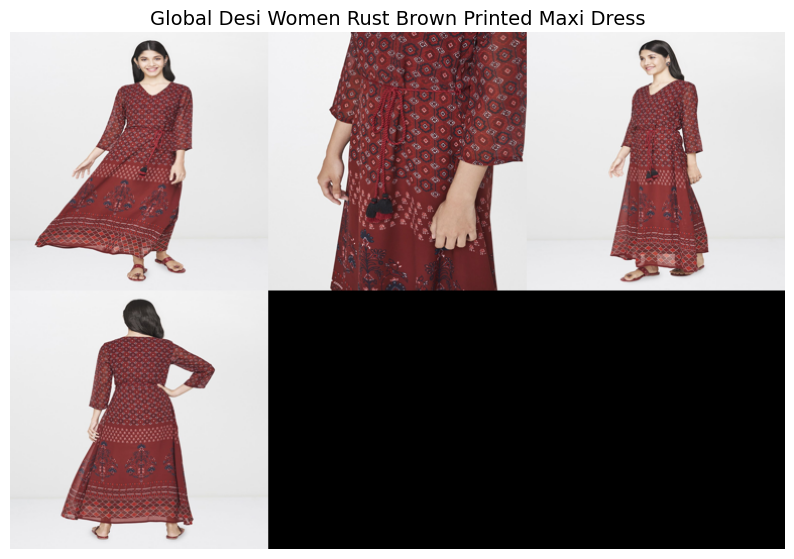

Displaying image for product: Palm Tree Girls CreamColoured  Yellow Floral Print ALine Dress with Belt


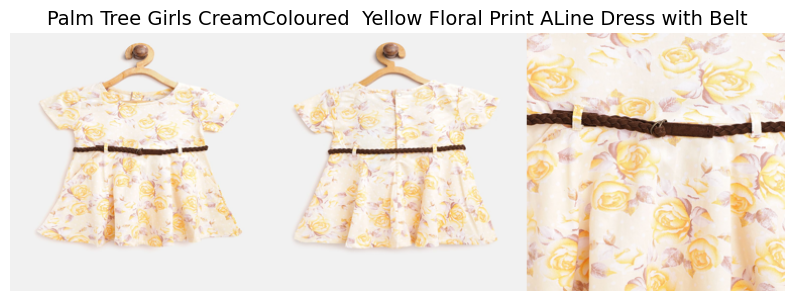

In [77]:
event = "tropical vacation"
gender = "male"
limit =2

recommendation_text = query_model_with_recommendations(gender=gender, event=event, limit=limit)
print("recommendation_text:", recommendation_text)

result = get_products_for_recommendation(event, gender, recommendation_text, limit)
print(result)

extract_and_display_image(result)


No recommendations found in the graph. The LLM will generate recommendations.
{'products': [{'name': 'Van Heusen Men Blue Checked SingleBreasted Slim Fit Formal Blazer', 'price': 3149.0, 'description': 'Blue Checked SingleBreasted Slim Fit Formal Blazer, has notched lapel, long sleeves', 'image': 'http://assets.myntassets.com/assets/images/productimage/2019/7/10/4b3eb5ce-46ed-4c37-a7e8-2ad2e9e491e41562738798144-1.jpg ~ http://assets.myntassets.com/assets/images/productimage/2019/7/10/a54b64f2-55a6-40ae-980c-c1d07ee986d41562738798164-2.jpg ~ http://assets.myntassets.com/assets/images/productimage/2019/7/10/115f3856-4a30-4baa-bf2c-7061278414501562738798188-3.jpg ~ http://assets.myntassets.com/assets/images/productimage/2019/7/10/a0c838fb-51c6-4aa4-b657-345d88dfe4161562738798212-4.jpg ~ http://assets.myntassets.com/assets/images/productimage/2019/7/10/4e5f1f28-7683-4333-a7b5-75fe084346861562738798238-5.jpg'}, {'name': 'Park Avenue Men Navy Blue SelfDesign Super Slim Fit SingleBreasted For

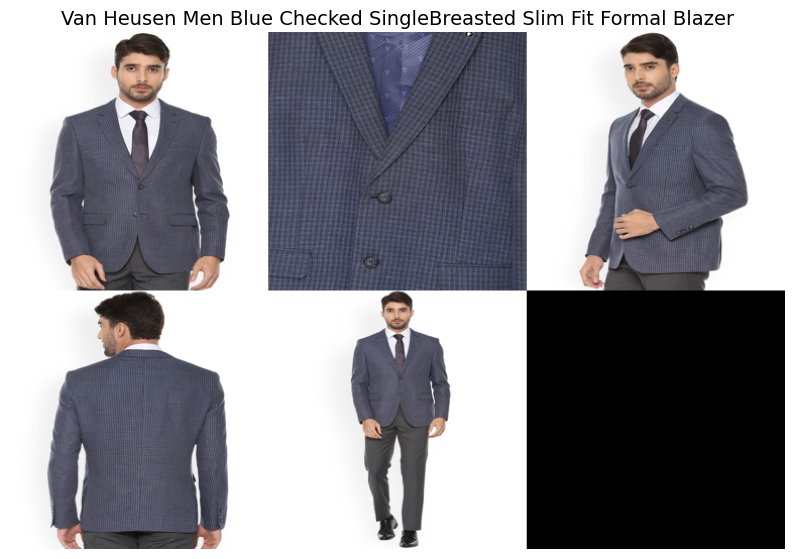

Displaying image for product: Park Avenue Men Navy Blue SelfDesign Super Slim Fit SingleBreasted Formal Blazer


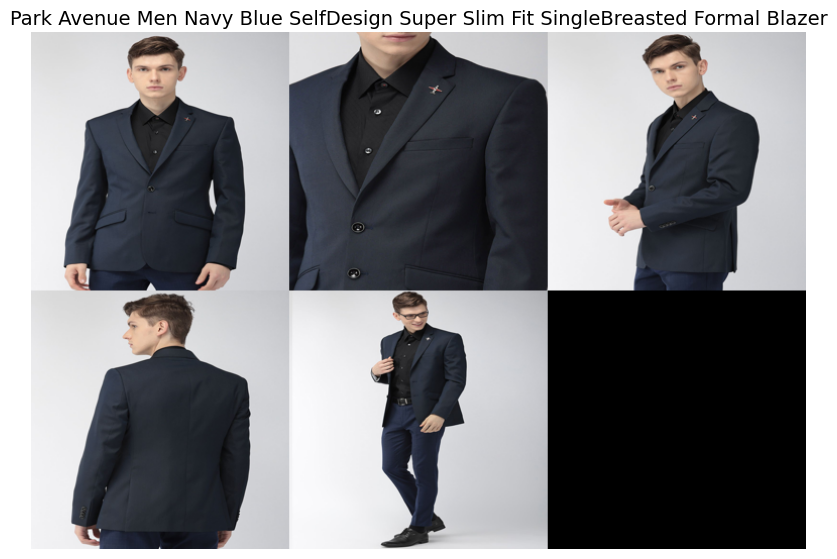

Displaying image for product: Park Avenue Men Blue Solid Super Slim Fit SingleBreasted Formal Blazer


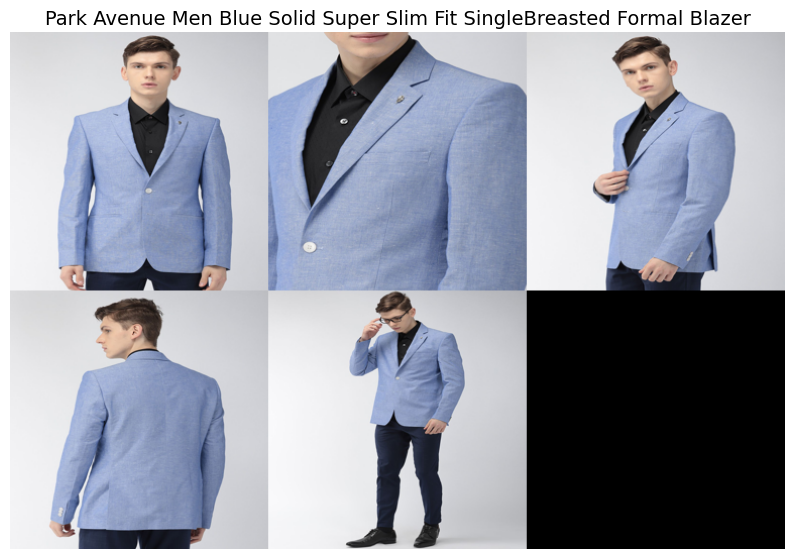

In [93]:
event = "conference"
gender = "man"
limit =3

recommendation_text = query_model_with_recommendations(gender=gender, event=event, limit=limit)

result = get_products_for_recommendation(event, gender, recommendation_text, limit)
print(result)

extract_and_display_image(result)


No recommendations found in the graph. The LLM will generate recommendations.
{'products': [{'name': 'Karmic Vision Women Pink Solid Fit  Flare Dress', 'price': 944.0, 'description': 'Pink and black solid woven fit and flare dress with lace inserts, has a shirt collar, short coldshoulder sleeves, button closure, an attached lining, flared hem', 'image': 'http://assets.myntassets.com/assets/images/10132291/2019/7/10/691e5a19-4b1a-4b5b-b665-9d572eea058f1562737674996-Karmic-Vision-Women-Pink-Shirt-Dress-281562737673368-1.jpg ~ http://assets.myntassets.com/assets/images/10132291/2019/7/10/a2eec99f-7a38-4cf0-9260-2f4fd45853191562737674969-Karmic-Vision-Women-Pink-Shirt-Dress-281562737673368-2.jpg ~ http://assets.myntassets.com/assets/images/10132291/2019/7/10/7c375994-ce05-4241-9d54-ef08bf1cc1171562737674942-Karmic-Vision-Women-Pink-Shirt-Dress-281562737673368-3.jpg ~ http://assets.myntassets.com/assets/images/10132291/2019/7/10/292e95b4-aaf7-4d30-b1e8-fcdcf6bc33fb1562737674917-Karmic-Visio

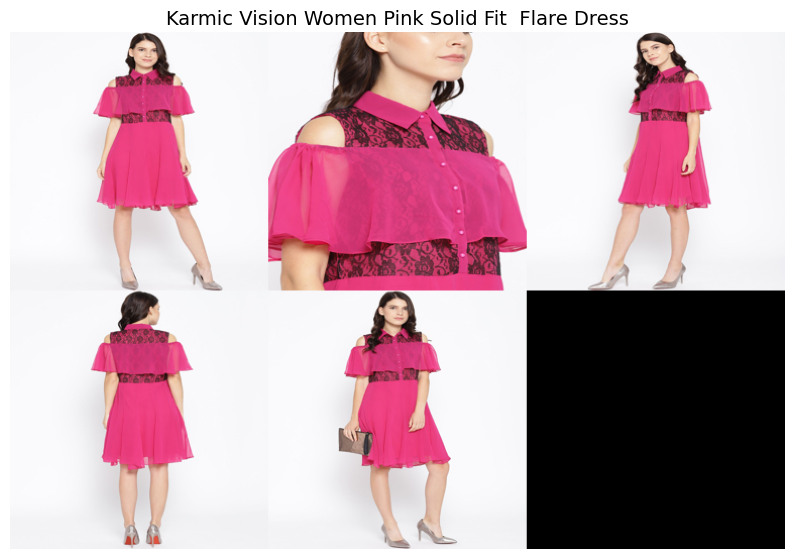

Displaying image for product: GAP Girls Red  Black Checked Fit and Flare Dress


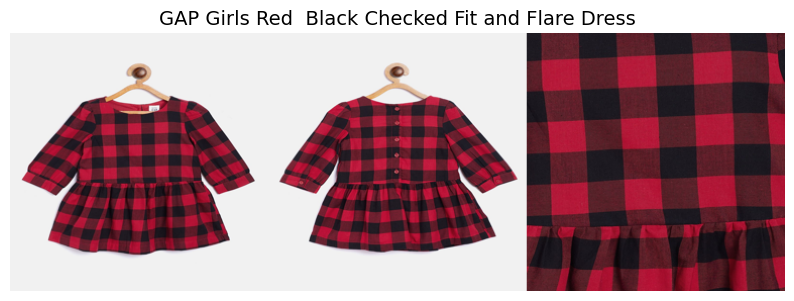

In [169]:
event = "party"
gender = "female"
limit =2

recommendation_text = query_model_with_recommendations(gender=gender, event=event, limit=limit)

result = get_products_for_recommendation(event, gender, recommendation_text, limit)
print(result)

extract_and_display_image(result)


##Remarks

1.   The choice of LLM significantly impacts accuracy. We kept the LLMs simple due to the resource constraints of using Google Colab.

2.   The quality of the input data plays a crucial role. Previous studies have reported challenges when working with CSV data compared to text.

3.   LLMGraphTransformer can also be employed to construct graph databases using LLMs, which is particularly suitable for text data.

4.   This project could be practically implemented as an outfit recommendation assistant agent, for instance, through chatbots or a FastAPI.

5.   Last but not least, like any other ML/AI project, this one can be realized in various ways, with numerous possible variations.

---
Let's connect and let me know if you have any comments/questions!
https://www.linkedin.com/in/mpaghababa/

